In [176]:
import pandas as pd
import seaborn as sns
import re


data = pd.read_csv("accounts_timelines.csv")
print(data.shape)
data.columns


(266121, 48)


Index(['account_type', 'author', 'avatar', 'city', 'city_code', 'continent',
       'continent_code', 'country', 'country_code', 'date', 'date_day',
       'date_hour', 'date_month', 'date_time_hour', 'date_weekday',
       'date_year', 'expanded_urls', 'full_name', 'full_text', 'gender',
       'hashtags', 'impact', 'impressions', 'language', 'location_name',
       'media_urls', 'mentioned_authors', 'page_type', 'reach_(new)', 'region',
       'region_code', 'thread_author', 'thread_created_date',
       'thread_entry_type', 'thread_id', 'thread_url', 'title',
       'twitter_author_id', 'twitter_channel_role', 'twitter_followers',
       'twitter_following', 'twitter_reply_count', 'twitter_reply_to',
       'twitter_retweet_of', 'twitter_retweets', 'twitter_tweets',
       'twitter_verified', 'url'],
      dtype='object')

# How to Handle Missing Data ?
One of the most common problems we have faced in Data Analysis is handling the missing values.

Roadmap to handle missing data
<img src="missingdata.png" width=600 height=500>

### Preprocessing Data
- Remove unwanted words
- Transform words to lowercase
- Remove stopwords
- Stemming words
- Create sparse matrix ( Bag of words )

In [177]:
test_str = data['full_text'].iloc[11]

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: RT @elciempies Mi canción favorita de Daniela Romo https://t.co/k30zhOxIsM
Cleaned text: RT @elciempies Mi canción favorita de Daniela Romo


In [214]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['full_text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['full_text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['full_text'].apply(lambda x: find_mentions(x))
    df['links'] = df['full_text'].apply(lambda x: find_links(x))
    
    return df

cleaned_values = process_text(data)
cleaned_values['hashtags'].head()

0                no
1    DíaDeLaBandera
2                no
3                no
4                no
Name: hashtags, dtype: object

## Users with less followers


In [215]:
less_followers = cleaned_values[cleaned_values['twitter_followers']<200]
less_followers.shape

(23318, 51)

In [216]:
less_followers.head()

,account_type,author,avatar,city,city_code,continent,continent_code,country,country_code,date,...,twitter_reply_count,twitter_reply_to,twitter_retweet_of,twitter_retweets,twitter_tweets,twitter_verified,url,text_clean,mentions,links
45,by number of retweets,Alfonso69960542,https://audiences.brandwatch.com/api/audiences...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-29 18:21:37,...,0,NaN,NaN,0,570,False,http://twitter.com/Alfonso69960542/statuses/12...,Otoño-invierno y asomándose la primavera #reto...,zolliker,https://t.co/7QbkUmxbPH
65,by number of retweets,Alfonso69960542,https://audiences.brandwatch.com/api/audiences...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-29 18:41:08,...,0,NaN,NaN,0,571,False,http://twitter.com/Alfonso69960542/statuses/12...,"No estoy llorando... no, la neta es que siiii",no,no
68,by number of retweets,Alfonso69960542,https://audiences.brandwatch.com/api/audiences...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-29 18:45:16,...,0,http://twitter.com/jorgeberry/statuses/1233913...,NaN,0,572,False,http://twitter.com/Alfonso69960542/statuses/12...,@jorgeberry @PRI_Nacional @lopezobrador_ Pero ...,jorgeberry PRI_Nacional lopezobrador_,no
77,by number of retweets,Alfonso69960542,https://audiences.brandwatch.com/api/audiences...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-29 18:56:18,...,0,http://twitter.com/X74Rafael/statuses/12338300...,NaN,0,573,False,http://twitter.com/Alfonso69960542/statuses/12...,@X74Rafael No me tardo nada Y vuelvo sin demor...,X74Rafael,no
78,by number of retweets,Alfonso69960542,https://audiences.brandwatch.com/api/audiences...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-29 18:57:10,...,0,http://twitter.com/X74Rafael/statuses/12338300...,NaN,0,574,False,http://twitter.com/Alfonso69960542/statuses/12...,@X74Rafael Voy a pipintarme y a popolvearme,X74Rafael,no


### Most frequent words and bigrams - all authors

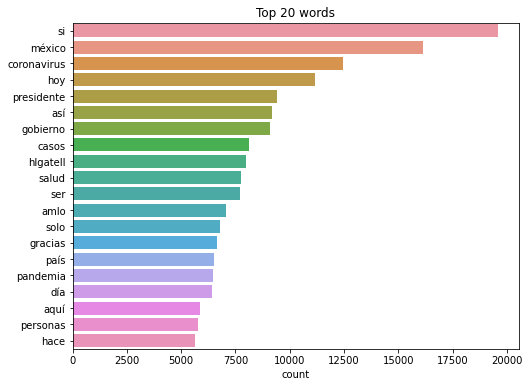

In [217]:
from nltk import FreqDist, word_tokenize
import matplotlib.pyplot as plt
from stop_words import get_stop_words

stopwords_spanish = get_stop_words('spanish')
stopwords_english = get_stop_words('english')
stopwords = stopwords_spanish + stopwords_english
stopwords.append("rt")

# Unigrams
word_freq = FreqDist(w for w in word_tokenize(' '.join(cleaned_values['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words')
plt.show()

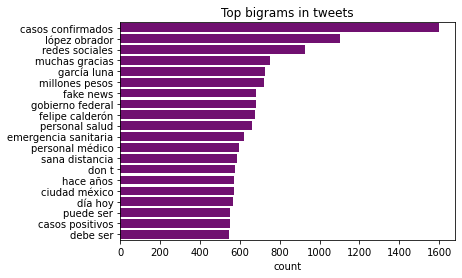

In [218]:
from nltk import bigrams

bigram_d = list(bigrams([w for w in word_tokenize(' '.join(cleaned_values['text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='purple')
plt.title('Top bigrams in tweets')
plt.show()

## Word cloud - all users

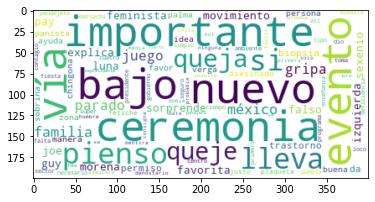

In [220]:
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

# Start with one review:
tweet_All = " ".join(review for review in word_freq)

# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)

# Display the generated image:
plt.imshow(wordcloud_ALL, interpolation='bilinear')


## Tweets using "fake news" and RedAmlo

In [221]:
import re
pattern1 = r"[Ff][Aa][Kk][Ee] [Nn][Ee][Ww][Ss]"
pattern2 = r"[Rr][Ee][Dd][Aa][Mm][Ll][Oo]"
pattern1_tweets = (cleaned_values[cleaned_values['text_clean'].str.contains(pattern1)])
pattern2_tweets = (cleaned_values[cleaned_values['text_clean'].str.contains(pattern2)])
filtered_tweets = pd.concat([pattern1_tweets, pattern2_tweets])


filtered_tweets['text_clean'].shape

(1457,)

In [222]:
filtered_tweets.drop_duplicates(keep=False,inplace=True) 
filtered_tweets['text_clean'].shape
filtered_tweets[['text_clean','twitter_reply_to','twitter_retweet_of']].to_csv("potential_tweets.csv",index=False)

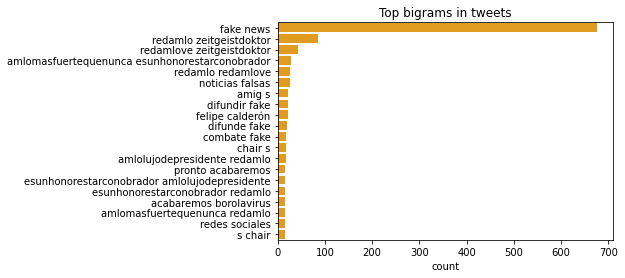

In [223]:
from nltk import bigrams


bigram_d = list(bigrams([w for w in word_tokenize(' '.join(filtered_tweets['text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))

d_fq = FreqDist(bg for bg in bigram_d)

freq = (pd.DataFrame(list(d_fq.items()), columns = ["Word","Frequency"]))

bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='orange')
plt.title('Top bigrams in tweets')
plt.show()

## Hashtags - all Tweets


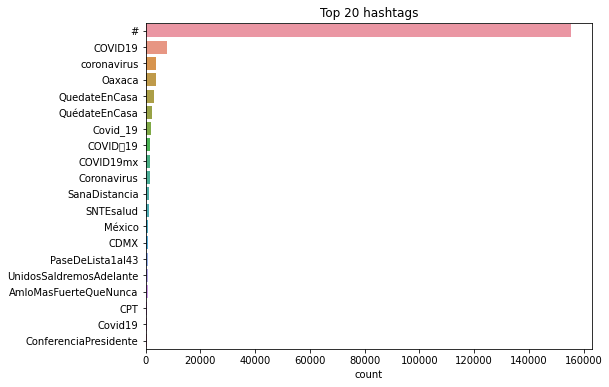

In [224]:

hashtag_freq = FreqDist(w for w in word_tokenize(' '.join(clean_hashtags['hashtags'])) )
                     
df_hashtag_freq = pd.DataFrame.from_dict(hashtag_freq, orient='index', columns=['count'])
top20hashtags = df_hashtag_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20hashtags['count'], top20hashtags.index)
plt.title('Top 20 hashtags')
plt.show()


## Authors

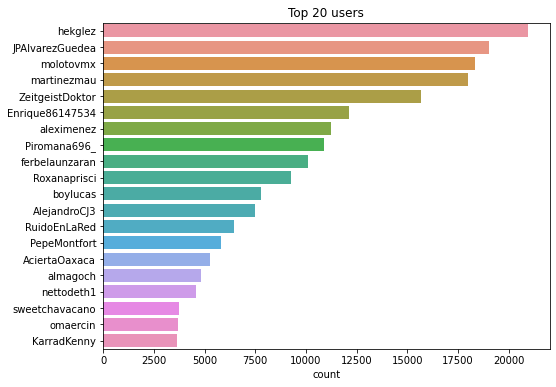

In [225]:
users = data['author']
users_freq = FreqDist(w for w in word_tokenize(' '.join(data['author'])) )
                    
df_users_freq = pd.DataFrame.from_dict(users_freq, orient='index', columns=['count'])
top20users = df_users_freq.sort_values('count',ascending=False).head(20)
all_users = df_users_freq.sort_values('count',ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(top20users['count'], top20users.index)
plt.title('Top 20 users')
plt.show()


In [226]:
all_users.index.name = 'users'
print(all_users)
users  = all_users.index.values.tolist()
print(users)

                 count
users                 
hekglez          20966
JPAlvarezGuedea  19007
molotovmx        18349
martinezmau      18014
ZeitgeistDoktor  15668
...                ...
riclarkdo          158
jesuslezamat       123
Oswi_Ramos         118
saviaga             84
LuisHum95052348      1

[76 rows x 1 columns]
['hekglez', 'JPAlvarezGuedea', 'molotovmx', 'martinezmau', 'ZeitgeistDoktor', 'Enrique86147534', 'aleximenez', 'Piromana696_', 'ferbelaunzaran', 'Roxanaprisci', 'boylucas', 'AlejandroCJ3', 'RuidoEnLaRed', 'PepeMontfort', 'AciertaOaxaca', 'almagoch', 'nettodeth1', 'sweetchavacano', 'omaercin', 'KarradKenny', 'josto03', 'leodiaz_escribe', 'genarolozano', 'oceloxochitl_', 'caboh_pm', 'MarkLevineNYC', 'cesargalicia_', 'EATZ_mx', 'xnmr__', 'MrShazan', 'mrsilva45', 'yak3001', 'Alex_Orue', 'memesaenz14', 'mrjavhomx', 'EabundioR', 'SerendipiaData', '_BarbaraCabrera', 'SaludEsCare', 'saguirre54', 'iecm', 'monitwitt', 'ccamacho88', 'Papanata80', 'Alfonso69960542', 'WSteinwascher'

In [227]:
import botometer
import keys

bom = botometer.Botometer(wait_on_ratelimit=True,
                          rapidapi_key=rapidapi_key,
                          **twitter_app_auth)

# Check a single account by screen name
#result = bom.check_account('@')

cols = ['author', 'bot_score']
lst = []
lst_deleted = []

## Check a sequence of accounts
for screen_name, result in bom.check_accounts_in(users):
    try:
        print([screen_name,result['display_scores']['user']])
        lst.append([screen_name,result['display_scores']['user']])
    except:
        lst_deleted.append(screen_name)
        pass


['hekglez', 3.3]
['JPAlvarezGuedea', 0.7]
['molotovmx', 2.7]
['martinezmau', 0.4]
['Enrique86147534', 1.2]
['aleximenez', 0.2]
['Piromana696_', 2.7]
['ferbelaunzaran', 0.4]
['Roxanaprisci', 1.3]
['boylucas', 0.2]
['AlejandroCJ3', 0.4]
['RuidoEnLaRed', 0.2]
['PepeMontfort', 0.1]
['AciertaOaxaca', 0.7]
['almagoch', 0.4]
['nettodeth1', 0.5]
['sweetchavacano', 0.2]
['omaercin', 0.2]
['KarradKenny', 3.9]
['josto03', 3.7]
['leodiaz_escribe', 0.9]
['genarolozano', 0.2]
['oceloxochitl_', 0.3]
['caboh_pm', 0.8]
['MarkLevineNYC', 0.3]
['cesargalicia_', 0.2]
['EATZ_mx', 0.2]
['xnmr__', 3.2]
['MrShazan', 0.2]
['mrsilva45', 0.1]
['yak3001', 0.3]
['Alex_Orue', 0.2]
['memesaenz14', 0.2]
['mrjavhomx', 0.8]
['EabundioR', 0.3]
['SerendipiaData', 1.2]
['_BarbaraCabrera', 0.4]
['SaludEsCare', 0.8]
['saguirre54', 1.7]
['iecm', 0.3]
['monitwitt', 1.1]
['ccamacho88', 0.3]
['Papanata80', 0.2]
['Alfonso69960542', 0.7]
['WSteinwascher', 0.2]
['socialtic', 0.4]
['esp_covid19', 3.2]
['arriagaantonio1', 2.8]
['Bri

deleted accounts: ['ZeitgeistDoktor']


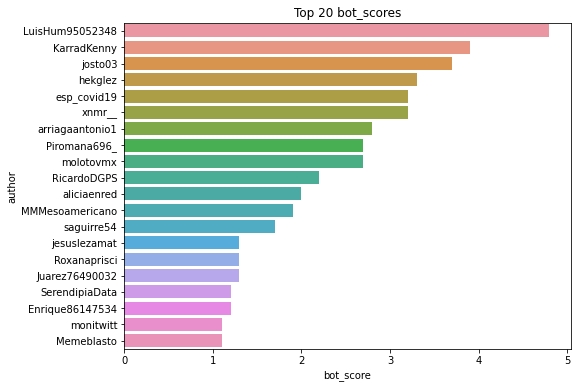

In [228]:
print("deleted accounts:",lst_deleted)
df1 = pd.DataFrame(lst, columns=cols)
top_bot_scores = df1.sort_values('bot_score',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top_bot_scores['bot_score'], top_bot_scores['author'])
plt.title('Top 20 bot_scores')
plt.show()


## Authors with score > 2.5

In [229]:
author_over25 = top_bot_scores[top_bot_scores['bot_score']>2.5]
author_over25list = author_over25['author'].to_list()
author_over25list = author_over25list + lst_deleted 
print(author_over25list)
author_over25list.remove('esp_covid19')
author_over25list


['LuisHum95052348', 'KarradKenny', 'josto03', 'hekglez', 'esp_covid19', 'xnmr__', 'arriagaantonio1', 'Piromana696_', 'molotovmx', 'ZeitgeistDoktor']


['LuisHum95052348',
 'KarradKenny',
 'josto03',
 'hekglez',
 'xnmr__',
 'arriagaantonio1',
 'Piromana696_',
 'molotovmx',
 'ZeitgeistDoktor']

In [232]:
tweets_bot_authors=cleaned_values[cleaned_values['author'].isin(author_over25list)]
print(tweets_bot_authors['author'].value_counts())
tweets_bot_authors.shape


hekglez            20966
molotovmx          18349
ZeitgeistDoktor    15668
Piromana696_       10903
KarradKenny         3662
josto03             3628
xnmr__              2423
arriagaantonio1      917
LuisHum95052348        1
Name: author, dtype: int64


(76517, 51)

## Top Words from Authors score > 2.5

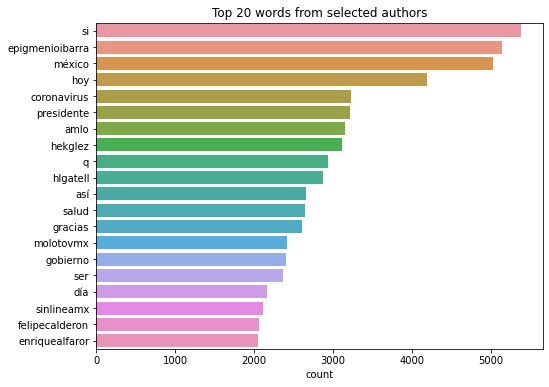

In [233]:
from nltk import FreqDist, word_tokenize
import matplotlib.pyplot as plt
from stop_words import get_stop_words

stopwords_spanish = get_stop_words('spanish')
stopwords_english = get_stop_words('english')
stopwords = stopwords_spanish + stopwords_english
stopwords.append("rt")

# Unigrams
word_freq = FreqDist(w for w in word_tokenize(' '.join(tweets_bot_authors['text_clean']).lower()) if 
                     (w not in stopwords) & (w.isalpha()))
df_word_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])
top20w = df_word_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20w['count'], top20w.index)
plt.title('Top 20 words from selected authors')
plt.show()

## Top bigrams from Authors score > 2.5

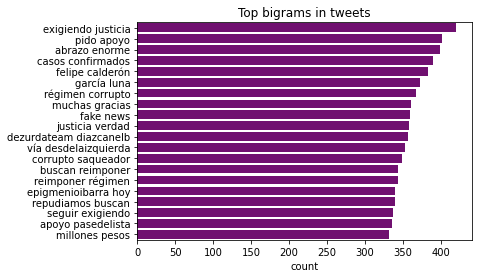

In [234]:
from nltk import bigrams

bigram_d = list(bigrams([w for w in word_tokenize(' '.join(tweets_bot_authors['text_clean']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
d_fq = FreqDist(bg for bg in bigram_d)
bgdf_d = pd.DataFrame.from_dict(d_fq, orient='index', columns=['count'])
bgdf_d.index = bgdf_d.index.map(lambda x: ' '.join(x))
bgdf_d = bgdf_d.sort_values('count',ascending=False)
sns.barplot(bgdf_d.head(20)['count'], bgdf_d.index[:20], color='purple')
plt.title('Top bigrams in tweets')
plt.show()

### Top Hashtags authors score > 2.5

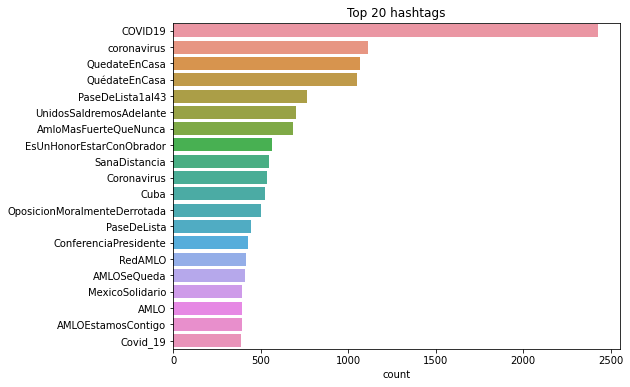

In [239]:
clean_hashtags = tweets_bot_authors[tweets_bot_authors['hashtags']!='no']

hashtag_freq = FreqDist(w for w in word_tokenize(' '.join(clean_hashtags['hashtags'])) )
                     
df_hashtag_freq = pd.DataFrame.from_dict(hashtag_freq, orient='index', columns=['count'])
top20hashtags = df_hashtag_freq.sort_values('count',ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(top20hashtags['count'], top20hashtags.index)
plt.title('Top 20 hashtags')
plt.show()


In [236]:
groups = clean_hashtags.groupby('author')['hashtags'].apply(','.join)
groups

author
KarradKenny        CaCalderonALaCarcel,BorolasVirus,MeDaraGustoVe...
Piromana696_       AlertaAmber,MeDaraGustoVerloTrasLasRejas LordC...
ZeitgeistDoktor    MeDaraGustoVerloTrasLasRejas LordCadeteMilitar...
arriagaantonio1    4taTransformación,AsíElWeso,FakeNews AccionesC...
hekglez            YoVoy8M VivasNosQueremos DespenalizaciónAborto...
josto03            FuerzaRayos,fuerzarayos,FuerzaRayos,FuerzaRayo...
molotovmx          MejoramientoUrbano,COVID2019mx Coronavirusmexi...
xnmr__             OXXOALaVueltaDeTuVida,MéxicoNoTeQuiere FelipeT...
Name: hashtags, dtype: object

In [237]:
def count_hashtags(sentence):
    count = len(sentence.split())
    return (count)
groups['counthash'] = groups.apply(count_hashtags)
groups['counthash']

author
KarradKenny          115
Piromana696_         951
ZeitgeistDoktor     9770
arriagaantonio1        6
hekglez            15554
josto03             1481
molotovmx           6311
xnmr__               260
Name: hashtags, dtype: int64

In [242]:
result = cleaned_values[cleaned_values['text_clean'].str.contains('RedAMLO')]